In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from arch.unitroot import PhillipsPerron,DFGLS
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/koueihei/Project-for-math-data-skills-YG/main/Data_and_code/MacroData.csv')
data = data.assign(Dates=pd.to_datetime(data.Dates)).set_index('Dates')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6252 entries, 2002-01-11 to 2022-01-10
Data columns (total 22 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Average daily coal consumption                       3916 non-null   float64
 1   Operating rate of blast furnaces                     475 non-null    float64
 2   All-steel wheel operating rate                       414 non-null    float64
 3   Semi-steel wheel operating rate                      410 non-null    float64
 4   Polyester filament operating rate                    508 non-null    float64
 5   PTA operating rate                                   413 non-null    float64
 6   Average daily output of crude steel                  459 non-null    float64
 7   Commercial housing transaction area of 30 cities(D)  4392 non-null   float64
 8   Commercial housing transaction area of 30 cities(W

In [108]:
keys = ('s1','s2','s3','s4','s5','s6','s7','d1','d2','d3','d4','d5','d6','d7','p1','p2','p3','s8','s9','s10','s11','s12')
indexing = dict(zip(data.columns.to_list(),keys))
reindexing = dict(zip(keys,data.columns.to_list()))

In [7]:
data1 = data.rename(columns = indexing)

data2 = data1.resample('W').mean().loc['2016-01-01':'2021-12-31',:]


In [ ]:
checker = data2.isnull().any(axis=0)
checker[checker == 0].index.tolist()
data2.info()

In [ ]:
data3 = data2.pct_change().dropna(how='all',axis=0).replace(to_replace=0, value=np.nan)

In [107]:
#basic description of variables
stationarity = {}
for ts in data3.columns:
    pp = PhillipsPerron(data3[ts].dropna())#PhillipsPerron(data3[ts].dropna())
    stationarity[reindexing[ts]]={
        'index':ts,
        'P values <br> of P-p test':pp.pvalue, #print newline within a cell of pandas
        'Mean':data3[ts].mean(),
        'Count':data3[ts].count(),
        'Std':data3[ts].std(),
        'Skewness':data3[ts].skew(),
        'Kurtosis':data3[ts].kurtosis(),
        'Start point': data3[ts].dropna().index[0].strftime("%m/%d/%Y"),
        'End point': data3[ts].dropna().index[-1].strftime("%m/%d/%Y")
        }
stationarity_df = pd.DataFrame(stationarity)#.items(),columns=['Var','P values of P-p test'])

stationarity_df=stationarity_df.T 
mapper =  {
        'P values <br> of P-p test':'{0:.2e}',
        'Mean':'{0:.3f}',
        'Count':'{:.0f}',
        'Skewness':'{0:.3f}',
        'Kurtosis':'{0:.3f}'
        }

stationarity_df.sort_values('index').style.format(mapper)

,index,P values of P-p test,Mean,Count,Std,Skewness,Kurtosis,Start point,End point
Commercial housing transaction area of 30 cities(D),d1,2.31e-30,0.140,312,1.108689,9.276,99.315,01/10/2016,12/26/2021
Commercial housing transaction area of 30 cities(W),d2,2.31e-30,0.140,312,1.108822,9.276,99.298,01/10/2016,12/26/2021
Cement Price Index,d3,1.58e-05,0.003,305,0.014570,2.441,14.260,01/10/2016,12/26/2021
Average Daily Sales of Passenger Car(Wholesale),d4,0.00e+00,0.167,276,0.674204,2.669,13.476,01/10/2016,12/26/2021
Average Daily Sales of Passenger Car(Retail),d5,0.00e+00,0.163,282,0.637975,2.179,9.805,01/10/2016,12/26/2021
Keqiao Textile Price Index,d6,2.29e-30,0.000,280,0.002588,1.449,10.409,01/10/2016,12/26/2021
CCFI composite index,d7,1.09e-12,0.005,302,0.019779,0.784,2.351,01/10/2016,12/26/2021
Edible Agricultural Products Price Index,p1,1.73e-09,0.000,263,0.011832,0.333,2.416,06/19/2016,12/26/2021
Production price index,p2,9.32e-16,0.002,257,0.008857,1.690,11.595,06/19/2016,12/26/2021
WTI spot price,p3,2.04e-30,0.011,310,0.185670,13.616,225.989,01/10/2016,12/26/2021


In [157]:
# Variables of supply side

setS = ['s1','s2','s3','s5','s6','s8']
print(np.corrcoef(data3[setS].dropna().T))


[[ 1.          0.09701647  0.3905624   0.36358876  0.00675945  0.41009678]
 [ 0.09701647  1.          0.0428526   0.05234774  0.12642697  0.24678432]
 [ 0.3905624   0.0428526   1.          0.28004587  0.05470648  0.12164425]
 [ 0.36358876  0.05234774  0.28004587  1.         -0.09927068  0.24721858]
 [ 0.00675945  0.12642697  0.05470648 -0.09927068  1.          0.14677922]
 [ 0.41009678  0.24678432  0.12164425  0.24721858  0.14677922  1.        ]]


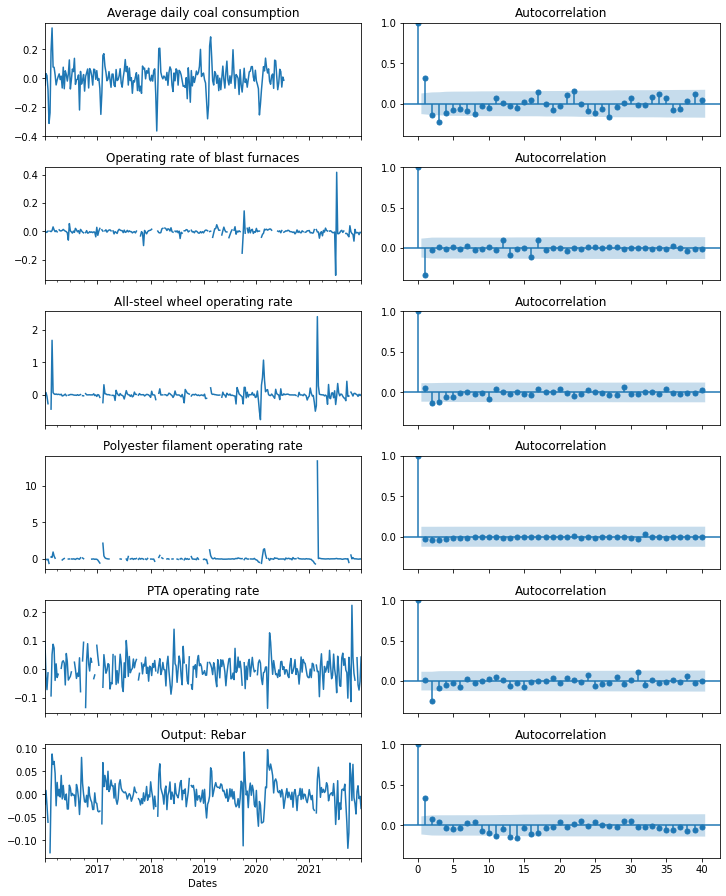

In [156]:
fig1, ax1 = plt.subplots(6,2,figsize=(10,12))
fig1.tight_layout(pad=0.4, w_pad=0.5, h_pad=1)
for i,ts in enumerate(setS):
    data3[ts].plot(ax=ax1[i,0])
    plot_acf(data3[ts].dropna(), lags=40,ax=ax1[i,1])
    ax1[i,0].set_title(reindexing[ts])
    ax1[i,1].set_title('Autocorrelation')
    ax1[i,1].set_ylim([-0.4,1])
    ax1[i,0].sharex(ax1[0,0])
    ax1[i,1].sharex(ax1[0,1])



In [12]:
def check_nan(data):
    '''
    ckeck if there are any nans in data and drop them.
    input -> pandas dataframe
    return -> data without nan, number of series remained
    '''
    checker = data.isnull().any(axis=0)
    if checker.any()==True:
        columns = checker[checker == 0].index.tolist()
        return data[columns], len(columns)
    else:
        return data, data.shape[1]
